<a href="https://colab.research.google.com/github/michael96247/CSE144-Applied-Machine-Learning-Homework/blob/main/CSE_144_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 4, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Michael Chen"
STUDENT_ID = "1772059"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past two years and reached an all time high of \$68,789.63 per bitcoin. Since reaching it's high, the price has dropped 75\%. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent Neural Network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b)

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [5]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [6]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

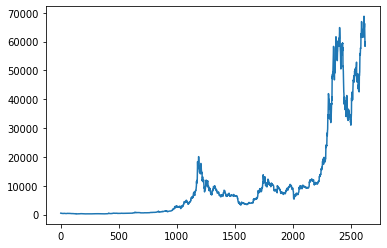

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

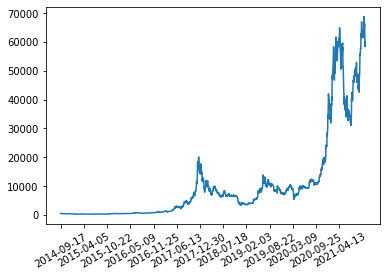

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the data in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [9]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = np.array(data['High'])

### YOUR CODE HERE ###

Remove missing values from the data.

In [10]:
# Remove enteries from the data with missing values. 
# The shape of the data after this step shoud be (2618,)

data_high = data_high[~np.isnan(data_high)] ### YOUR CODE HERE ###


Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [11]:
### YOUR CODE HERE ###
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1)) ### YOUR CODE HERE ###

data_normalized = scaler.fit_transform(data_high.reshape((-1, 1))) ### YOUR CODE HERE ###

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [12]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [13]:
# Choose the number of time steps that the model "looks back"
time_steps = 5 ### YOUR CODE HERE ###

# Produce your dataset based on the number of days the model could look back

### YOUR CODE HERE ###
X, y = create_dataset(data_normalized, time_steps)

In [14]:
# Check the shape of your dataset; should be (2618-time_steps-1, time_steps) and (2618-time_steps-1,)
print(X.shape, y.shape)

(2612, 5, 1) (2612, 1)


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [15]:
### YOUR CODE HERE ###
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0 : train_size], X[train_size: len(data_high)]
y_train, y_test = y[0 : train_size], y[train_size: len(data_high)]

For this dataset, you need to reshape the partitions for the model to be able to process them.

In [16]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# The shape of the training and test data after this step should be 
# ((2618-time_steps-1) * 80%, 1, time_steps) and ((2618-time_steps-1) * 20%, 1, time_steps), respectively.
X_train.shape

(2089, 1, 5)

In [17]:
X_test.shape

(523, 1, 5)

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary. Train the model and plot loss values.

In [18]:
# Build your model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error


model = Sequential()
model.add(LSTM(1, input_shape=(1, time_steps)))
model.add(Dense(4))
model.add(Dense(1))

print(model.summary())

### YOUR CODE HERE ###

loss = "mean_squared_error" ### YOUR CODE HERE ###

opt =  tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.009, name="SGD", decay=1e-6) ### YOUR CODE HERE ###

metrics = "mean_squared_error" ### YOUR CODE HERE ###

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 28        
                                                                 
 dense (Dense)               (None, 4)                 8         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
batchsize = 10 ### YOUR CODE HERE ###

epochs = 5 ### YOUR CODE HERE ###

model.compile(loss = loss, optimizer = opt, metrics = metrics)

# Fit model - Use 20% validation split
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batchsize, validation_split=0.2, shuffle=False) ### YOUR CODE HERE ###

Epoch 1/5
168/168 [==============================] - 8s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2/5
168/168 [==============================] - 1s 4ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 3/5
168/168 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 4/5
168/168 [==============================] - 1s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 5/5
168/168 [==============================] - 1s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0065 - val_mean_squared_error: 0.0065


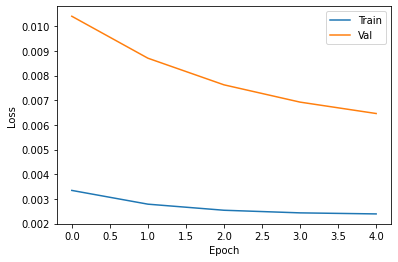

In [20]:
# Plot the model loss

### YOUR CODE HERE ###

def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(model_info):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(history)
# plot_accuracies(history)

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [21]:
# Build your model

model = Sequential()
model.add(LSTM(8, input_shape=(1, time_steps)))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(1))

print(model.summary())


### YOUR CODE HERE ###

loss = "mean_squared_error" ### YOUR CODE HERE ###

opt = "adam" ### YOUR CODE HERE ###

metrics = "mean_squared_error" ### YOUR CODE HERE ###

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 448       
                                                                 
 dense_2 (Dense)             (None, 128)               1152      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,729
Trainable params: 1,729
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
batchsize = 100 ### YOUR CODE HERE ###
epochs = 100 ### YOUR CODE HERE ###

model.compile(loss = loss, optimizer = opt, metrics = metrics)

# Fit model
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batchsize, validation_split=0.2, shuffle=False) ### YOUR CODE HERE ###

Epoch 1/100
17/17 [==============================] - 2s 31ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 8.8502e-04 - mean_squared_error: 8.8502e-04 - val_loss: 6.0132e-04 - val_mean_squared_error: 6.0132e-04
Epoch 7/100
17/17

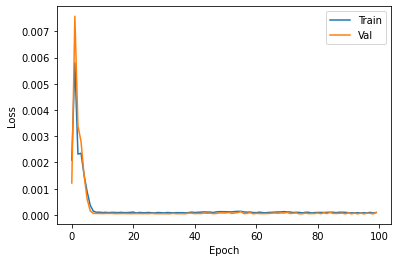

In [23]:
# Plot the model loss

### YOUR CODE HERE ###

def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(model_info):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(history)

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

**Note:** Your model is trained on normalized data. In order to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [24]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
len(trainPredict)

17/17 [==============================] - 0s 2ms/step


2089

In [25]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredict = (trainPredict.flatten())
testPredict = (testPredict.flatten())

In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data['High'])
# trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps: len(trainPredict) + time_steps] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data['High'])
# testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + time_steps * 2 - 1: len(data['High']) -1 ] = testPredict

<class 'numpy.ndarray'>
(2089,)
(2622,)
(2622,)


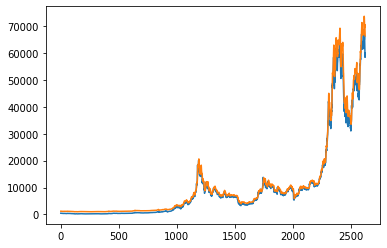

In [27]:
### YOUR CODE HERE ###
predict = np.concatenate((trainPredict, testPredict))
print(type(trainPredict))
# predict = predict.reshape(-1, 1)

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g = sns.lineplot(x = np.linspace(1, 2622, 2618-time_steps-1), y = predict)

print(trainPredict.shape)
print(data['High'].values.reshape(-1).shape)
print(data['High'].values.shape)

# plt.plot(x = np.linspace(1, 2618-time_steps-1, 2618-time_steps-1), y = data['High'].values.reshape(-1), linewidth=2)
# plt.plot(trainPredictPlot, 'g')
# plt.plot(testPredictPlot, 'r')
# plt.show()
# g = sns.lineplot(x = np.linspace(1, 2618-time_steps-1, 2618-time_steps-1), y = scaler.inverse_transform (predict)) # y = data['High'].values.reshape(-1)
# g.set(xticks=np.arange(0,2500,200))
# g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

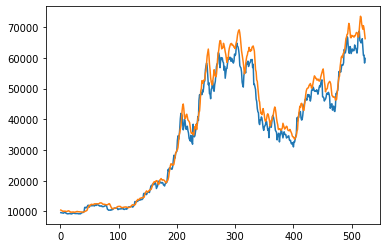

In [28]:
g = sns.lineplot(x = np.linspace(1,len(testPredict),len(testPredict)), y = data['High'].values.reshape(-1)[-1 * len(testPredict):])
g = sns.lineplot(x = np.linspace(1, len(testPredict), len(testPredict)), y = testPredict)

[YOUR ANSWER HERE]
Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

I increased the LSTM from 1 to 8 and the number of neurons at the dense layer from 4 to 128. I also added a 0.5 dropout layer to prevent overfitting. For the number of days the model 'look back', I tried 500, 100, 10, 1, and 5. For 500 and 100, the losses graph is extremely unstable. Then I tried 'look back' of 10 and 1, which is far more stable compared to 'look back' of 500 and 100. And finally, I tried look back of 5, which has the most stable losses graph compared to all the different 'look back' I tried (500, 100, 10, 1). So generally the model performs better with fewer "look back days" (something between 1 to 10 performs pretty well). I tried adding more dense layers to the model but the result is worse, so adding more dense layers do not help the model.

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional
from tensorflow.keras.models import Model
import string
import textwrap

max_sequence_len = 1000

# Load data  
(X, y), (_, _) = tf.keras.datasets.reuters.load_data(
    path="reuters.npz", maxlen = max_sequence_len, test_split = 0.0)

# (X_train, y_train)

### YOUR CODE HERE ###

# Clean and pre-process the data
word_dict = tf.keras.datasets.reuters.get_word_index()
word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

vocab_size = len(word_dict.keys())
inverse_word_dict = {value:key for key,value in word_dict.items()}


def encode_review(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word == '' or word == '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

def decode_review(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if (encoded_word == 0):
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))



### YOUR CODE HERE ###

# Print sample data

print(decode_review(X[-1], inverse_word_dict), end='\n\n')

print('Label: ', y[-1] )

### YOUR CODE HERE ###

550378/550378 [==============================] - 0s 0us/step
<START> congress should give the u s agriculture secretary the authority to keep the 1987 soybean loan rate at the
current effective rate of 4 56 dlrs per bushel in order to help resolve the problem of soybean export competitiveness
usda undersecretary dan amstutz said speaking to reporters following a senate agriculture appropriations hearing amstutz
suggested that one way out of the current soybean program dilemma would be for congress to allow the loan rate to remain
at 4 56 dlrs he indicated if the loan rate were 4 56 dlrs usda could then consider ways to make u s soybeans more
competitive such as using certificates to further buydown the loan rate under current law the 1987 soybean loan rate
cannot be less than 4 77 dlrs per bu amstutz' suggestion would be for congress to change the farm bill to allow usda to
leave the soybean loan rate at 4 56 dlrs in crop year 1987 rather than increase it to 4 77 dlrs the 1986 effectiv

### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [30]:
### YOUR CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y)

In [31]:
print(decode_review(X_train[-1], inverse_word_dict), end='\n\n')

print('Label: ', y_train[-1])

<START> industrial production excluding construction and adjusted for the number of working days fell 1 5 pct in
december from year earlier levels the national statistics office said it was also a sharp 16 8 pct below the november
level it said the office said the production index base 1980 stood at 97 3 in december against an adjusted 116 9 in
november and 98 8 in december 1985 reuter 3

Label:  30


### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [32]:
# Build your model
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 500)(input_layer)

x = LSTM(32)(x) 
# x = Bidirectional(tf.keras.layers.GRU(32))(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.8)(x)

x = Dense(46, activation='sigmoid')(x)
reuters_model = Model(input_layer, x)

### YOUR CODE HERE ###
# tf.keras.losses.SparseCategoricalCrossentropy()
loss = tf.keras.losses.SparseCategoricalCrossentropy() ### YOUR CODE HERE ###
# tf.keras.optimizers.Adam(2e-4)
opt =  "adam" ### YOUR CODE HERE ###

metrics = metrics=['accuracy'] ### YOUR CODE HERE ###

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 500)         15491500  
                                                                 
 lstm_2 (LSTM)               (None, 32)                68224     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0     

In [33]:
batchsize = 128 ### YOUR CODE HERE ###
epochs =  5 ### YOUR CODE HERE ###

X_train = pad_sequences(X_train, maxlen=max_sequence_len)

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/5
57/57 [==============================] - 6s 66ms/step - loss: 3.7056 - accuracy: 0.1953 - val_loss: 3.3629 - val_accuracy: 0.4905
Epoch 2/5
57/57 [==============================] - 3s 54ms/step - loss: 3.3983 - accuracy: 0.2432 - val_loss: 2.7422 - val_accuracy: 0.5239
Epoch 3/5
57/57 [==============================] - 3s 54ms/step - loss: 3.0718 - accuracy: 0.3447 - val_loss: 2.0442 - val_accuracy: 0.5445
Epoch 4/5
57/57 [==============================] - 3s 53ms/step - loss: 2.8614 - accuracy: 0.3299 - val_loss: 1.9915 - val_accuracy: 0.5418
Epoch 5/5
57/57 [==============================] - 3s 53ms/step - loss: 2.7337 - accuracy: 0.3539 - val_loss: 1.9268 - val_accuracy: 0.5362


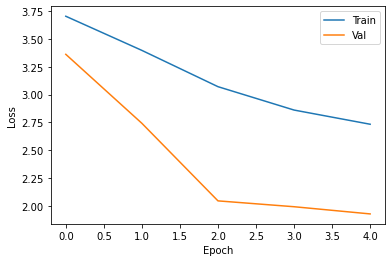

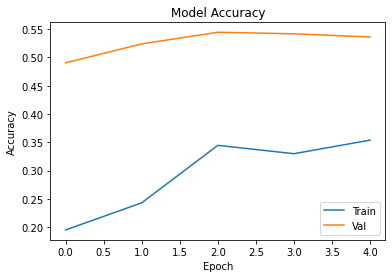

In [34]:
# Plot the model loss and accuracy on training and validation sets
plot_losses(history)
plot_accuracies(history)
### YOUR CODE HERE ###

### Part d) More Advanced RNN Model (15 points)
In this part, you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [35]:
# Build your model

input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 1000)(input_layer)

# x = LSTM(128)(x) 
x = Bidirectional(tf.keras.layers.GRU(128))(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(46, activation='sigmoid')(x)
model = Model(input_layer, x)

### YOUR CODE HERE ###

loss = tf.keras.losses.SparseCategoricalCrossentropy() ### YOUR CODE HERE ###

opt = "adam" ### YOUR CODE HERE ###

metrics = ['accuracy'] ### YOUR CODE HERE ###

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1000, 1000)        30983000  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              867840    
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 46)                47150     
                                                           

In [36]:
batchsize = 128 ### YOUR CODE HERE ###
epochs =  10 ### YOUR CODE HERE ###

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10
57/57 [==============================] - 11s 145ms/step - loss: 2.3990 - accuracy: 0.3986 - val_loss: 1.8700 - val_accuracy: 0.4855
Epoch 2/10
57/57 [==============================] - 8s 134ms/step - loss: 1.8226 - accuracy: 0.5208 - val_loss: 1.6935 - val_accuracy: 0.5618
Epoch 3/10
57/57 [==============================] - 8s 134ms/step - loss: 1.5585 - accuracy: 0.5876 - val_loss: 1.6038 - val_accuracy: 0.5802
Epoch 4/10
57/57 [==============================] - 8s 134ms/step - loss: 1.3158 - accuracy: 0.6547 - val_loss: 1.5636 - val_accuracy: 0.6086
Epoch 5/10
57/57 [==============================] - 8s 134ms/step - loss: 1.0842 - accuracy: 0.7170 - val_loss: 1.5269 - val_accuracy: 0.6409
Epoch 6/10
57/57 [==============================] - 8s 134ms/step - loss: 0.9127 - accuracy: 0.7510 - val_loss: 1.5420 - val_accuracy: 0.6492
Epoch 7/10
57/57 [==============================] - 8s 134ms/step - loss: 0.7874 - accuracy: 0.7825 - val_loss: 1.5942 - val_accuracy: 0.6559
Epoch

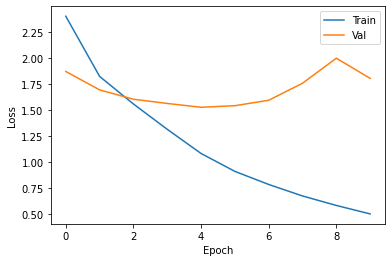

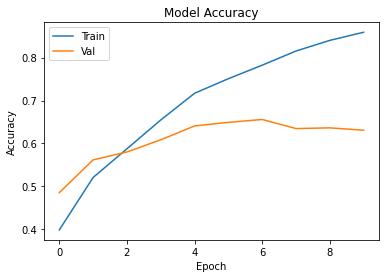

In [37]:
# Plot the model loss and accuracy
plot_losses(history)
plot_accuracies(history)
### YOUR CODE HERE ###

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [38]:
### YOUR CODE HERE ###
X_test = pad_sequences(X_test, maxlen=max_sequence_len)
predict = model.predict(X_test)

y_test_list = list(y_test)

71/71 [==============================] - 3s 36ms/step


In [39]:
predict = [np.argmax(i) for i in predict]
c = 0
predict_counts = [0] * 46
test_counts = [0] * 46
for i in range(len(predict)):
  test_counts[y_test[i]] += 1
  if(predict[i] == y_test[i]):
    predict_counts[y_test[i]] += 1
accuracies = [i / j for i, j in zip(predict_counts, test_counts)] 
for i, j in enumerate(accuracies):
  print("Class {} prediction accuracy: ".format(i), j)

Class 0 prediction accuracy:  0.5
Class 1 prediction accuracy:  0.6448598130841121
Class 2 prediction accuracy:  0.10526315789473684
Class 3 prediction accuracy:  0.8729559748427673
Class 4 prediction accuracy:  0.7319587628865979
Class 5 prediction accuracy:  0.0
Class 6 prediction accuracy:  0.25
Class 7 prediction accuracy:  0.0
Class 8 prediction accuracy:  0.5
Class 9 prediction accuracy:  0.48
Class 10 prediction accuracy:  0.7096774193548387
Class 11 prediction accuracy:  0.45263157894736844
Class 12 prediction accuracy:  0.16666666666666666
Class 13 prediction accuracy:  0.2857142857142857
Class 14 prediction accuracy:  0.16666666666666666
Class 15 prediction accuracy:  0.0
Class 16 prediction accuracy:  0.1834862385321101
Class 17 prediction accuracy:  0.2
Class 18 prediction accuracy:  0.7647058823529411
Class 19 prediction accuracy:  0.5735294117647058
Class 20 prediction accuracy:  0.5441176470588235
Class 21 prediction accuracy:  0.32
Class 22 prediction accuracy:  0.0
Cla

In [40]:
from sklearn.metrics import classification_report

target_names = ["{}".format(i) for i in range(46)]
print(classification_report(y_test_list, predict, target_names = target_names) )


              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.82      0.64      0.72       107
           2       0.08      0.11      0.09        19
           3       0.88      0.87      0.88       795
           4       0.78      0.73      0.76       485
           5       0.00      0.00      0.00         4
           6       0.25      0.25      0.25        12
           7       0.00      0.00      0.00         4
           8       0.26      0.50      0.34        36
           9       0.43      0.48      0.45        25
          10       0.51      0.71      0.59        31
          11       0.48      0.45      0.47        95
          12       0.11      0.17      0.13        12
          13       0.38      0.29      0.32        42
          14       0.33      0.17      0.22         6
          15       0.00      0.00      0.00         6
          16       0.33      0.18      0.24       109
          17       0.08    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
